# Final Project
Quinn Frank <br>
November 23, 2020

In [1]:
# Import NLTK to load training data
import nltk
nltk.download("tagsets")
nltk.download("brown")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
# Potentially: http://www.anc.org/software/anc-tool/

# Import my modules
from hmm import HMM
from blstm import *
from tagging_results import TaggingResults

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
# CAN LOAD PRE-TRAINED MODELS HERE

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

#hmm = unpickle("models/hmm")
#summ = unpickle("models/blstm_train_summ")
#net = torch.load("models/blstm")

## Step 2: Generative Model

In [2]:
train_size, test_size = 10000, 2000   # actual test set may be < test_size
train = nltk.corpus.brown.tagged_sents(tagset="universal")[:train_size]
test = nltk.corpus.brown.tagged_sents(tagset="universal")[train_size:train_size+test_size]

In [3]:
hmm = HMM()
%time hmm.fit(train)
%time test_sents, y_true, y_predict = hmm.split_predict(test)

Wall time: 1min 33s
Wall time: 3.81 s


In [4]:
# Calculate accuracy of HMM on both datasets
hmm_train = TaggingResults(hmm, train, hmm.vocab, hmm.tagset)
hmm_test = TaggingResults(hmm, test, hmm.vocab, hmm.tagset)

hmm_train.get_accuracy()
hmm_test.get_accuracy()


Accuracy
--------
total               0.9769
in vocab            0.9769
out of vocab           NaN
ambiguous tokens    0.9254
dtype: float64

Accuracy
--------
total               0.9188
in vocab            0.9647
out of vocab        0.2622
ambiguous tokens    0.8671
dtype: float64


## Step 3: Discriminative Model

In [5]:
untagged_train = nltk.corpus.brown.sents()[:train_size]
%time embedder = train_fasttext(untagged_train)

# Also store the vocabulary for later
net_vocab = pd.Index(sorted(set(sum(untagged_train, []))))

Wall time: 9.4 s


In [7]:
train_set = POSDataset(train, embedder, hmm.tagset)
test_set = POSDataset(test, embedder, hmm.tagset)

# Network is loaded onto a GPU by default
# (to run on cpu, remove .cuda() and set use_cuda below to False)
net = BLSTM(100, len(hmm.tagset), 128, 2, 0.2)

In [18]:
net.cuda()
%time summ = train_BLSTM(net, train_set, test_set, \
                         num_epochs=40, batch_size=16, use_cuda=True, \
                         print_every=5, train_summ=summ)

- EPOCH 5:
  train loss = 0.7001168727874756
  accuracy   = 0.8426 (train) / 0.8323 (test)
----------------------------
- EPOCH 10:
  train loss = 0.7223856449127197
  accuracy   = 0.8465 (train) / 0.8353 (test)
----------------------------
- EPOCH 15:
  train loss = 0.7266753315925598
  accuracy   = 0.8482 (train) / 0.8385 (test)
----------------------------
- EPOCH 20:
  train loss = 0.7150929570198059
  accuracy   = 0.8521 (train) / 0.8399 (test)
----------------------------
- EPOCH 25:
  train loss = 0.6909984946250916
  accuracy   = 0.8546 (train) / 0.8429 (test)
----------------------------
- EPOCH 30:
  train loss = 0.6948869824409485
  accuracy   = 0.8561 (train) / 0.8451 (test)
----------------------------
- EPOCH 35:
  train loss = 0.6797302961349487
  accuracy   = 0.8594 (train) / 0.8476 (test)
----------------------------
- EPOCH 40:
  train loss = 0.6707044839859009
  accuracy   = 0.8605 (train) / 0.8474 (test)
----------------------------
Wall time: 7min 24s


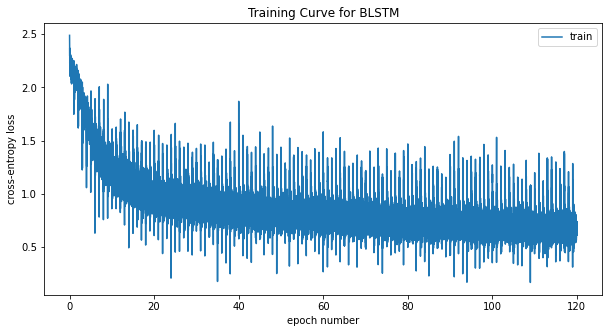

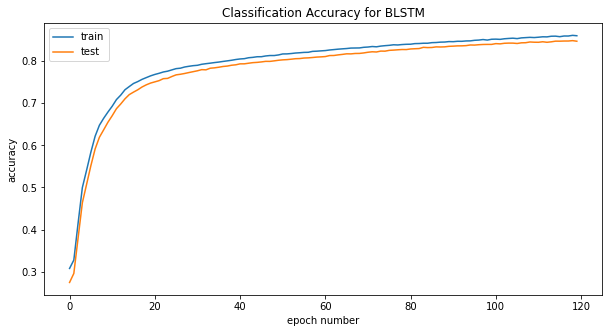


Accuracy
--------
total               0.8590
in vocab            0.8590
out of vocab           NaN
ambiguous tokens    0.8441
dtype: float64

Accuracy
--------
total               0.8436
in vocab            0.8536
out of vocab        0.7247
ambiguous tokens    0.7698
dtype: float64


In [19]:
net.cpu()
plot_train_summ(summ)

# Calculate accuracy of BiLSTM on both datasets
net_train = TaggingResults(net, train, net_vocab, hmm.tagset, embedder)
net_test = TaggingResults(net, test, net_vocab, hmm.tagset, embedder)

net_train.get_accuracy()
net_test.get_accuracy()

In [23]:
# STORE MODELS HERE ONCE TRAINED

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

enpickle(hmm, "models/hmm")
enpickle(summ, "models/blstm_train_summ")
torch.save(net, "models/blstm")

# Step 4: Application to Artificial Data

In [32]:
# Generate an artificial tagged dataset to test on
%time artificial = hmm.generate(1000)

Wall time: 12.8 s


In [33]:
hmm_art = TaggingResults(hmm, artificial, hmm.vocab, hmm.tagset)
net_art = TaggingResults(net, artificial, net_vocab, hmm.tagset, embedder)

hmm_art.get_accuracy()
net_art.get_accuracy()


Accuracy
--------
total               0.9783
in vocab            0.9783
out of vocab           NaN
ambiguous tokens    0.8940
dtype: float64

Accuracy
--------
total               0.7811
in vocab            0.7835
out of vocab        0.7522
ambiguous tokens    0.7007
dtype: float64


In [43]:
net_test.get_sent(4)

             true predict correct? oov? ambiguous?
token                                             
Then          ADV     ADV        ✓                
,               .       .        ✓                
if            ADP     ADP        ✓                
the           DET     DET        ✓                
middle        ADJ    NOUN                         
number       NOUN    NOUN        ✓                
is           VERB    VERB        ✓                
activated    VERB    VERB        ✓    *           
to            ADP     ADP        ✓               *
its           DET     DET        ✓                
greatest      ADJ     ADJ        ✓                
potential    NOUN    NOUN        ✓               *
in            ADP     ADP        ✓               *
terms        NOUN    NOUN        ✓                
of            ADP     ADP        ✓                
this          DET     DET        ✓                
square       NOUN    NOUN        ✓               *
,               .       .      

# Step 5: Application to Real Data

In [833]:
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

In [844]:
string = "I'm not making a sentence!  Hooray for #sentences..."
pos_tag(word_tokenize(sent_tokenize(string)[1]), tagset="universal")

[('Hooray', 'NOUN'),
 ('for', 'ADP'),
 ('#', '.'),
 ('sentences', 'NOUN'),
 ('...', '.')]

In [879]:
moby_words = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
moby = list(map(lambda sent: pos_tag(word_tokenize(sent), tagset='universal'),
                sent_tokenize(' '.join(moby_words))))

In [880]:
moby_set = POSDataset(moby[:1000], embedder, hmm.tagset)
model.cpu()
g_true, g_predict = hmm.split_predict(moby[:1000])
d_true, d_predict = model.split_predict(moby_set)

In [884]:
idx = 100
print(moby[idx])
print(g_true[idx])
print(g_predict[idx])
print(d_true[idx])
print(d_predict[idx])

[('By', 'ADP'), ('art', 'NOUN'), ('is', 'VERB'), ('created', 'VERB'), ('that', 'ADP'), ('great', 'ADJ'), ('Leviathan', 'NOUN'), (',', '.'), ('called', 'VERB'), ('a', 'DET'), ('Commonwealth', 'NOUN'), ('or', 'CONJ'), ('State', 'NOUN'), ('--', '.'), ('(', '.'), ('in', 'ADP'), ('Latin', 'NOUN'), (',', '.'), ('Civitas', 'NOUN'), (')', '.'), ('which', 'DET'), ('is', 'VERB'), ('but', 'CONJ'), ('an', 'DET'), ('artificial', 'ADJ'), ('man', 'NOUN'), ('.', '.'), ("''", '.')]
[2, 6, 10, 10, 2, 1, 6, 0, 10, 5, 6, 4, 6, 0, 0, 2, 6, 0, 6, 0, 5, 10, 4, 5, 1, 6, 0, 0]
[5, 6, 10, 10, 2, 1, 6, 0, 10, 5, 6, 4, 7, 0, 0, 2, 7, 0, 11, 0, 5, 10, 4, 5, 1, 6, 0, 0]
[2, 6, 10, 10, 2, 1, 6, 0, 10, 5, 6, 4, 6, 0, 0, 2, 6, 0, 6, 0, 5, 10, 4, 5, 1, 6, 0, 0]
[2, 6, 10, 10, 2, 1, 6, 0, 10, 5, 6, 4, 6, 0, 0, 2, 6, 0, 6, 0, 5, 10, 4, 5, 1, 6, 0, 0]


In [897]:
import re

hyperlink = r"http\S*\s"
trump_words = ' ! '.join(pd.read_json("trump.json", encoding="utf8").text)
trump_words = re.sub(hyperlink, "", trump_words)

trump = list(map(lambda sent: pos_tag(word_tokenize(sent), tagset='universal'),
                 sent_tokenize(trump_words)))

In [901]:
trump_set = POSDataset(trump, embedder, hmm.tagset)
model.cpu()
g_true, g_predict = hmm.split_predict(trump)
d_true, d_predict = model.split_predict(trump_set)

In [904]:
idx = 300
print(trump[idx])
print(g_true[idx])
print(g_predict[idx])
print(d_true[idx])
print(d_predict[idx])

[('Tractors', 'NOUN'), ('blocked', 'VERB'), ('doors', 'NOUN'), ('&', 'CONJ'), ('amp', 'NOUN'), (';', '.'), ('windows', 'NOUN'), ('were', 'VERB'), ('covered', 'VERB'), ('with', 'ADP'), ('thick', 'ADJ'), ('cardboard', 'NOUN'), ('so', 'ADP'), ('that', 'DET'), ('observers', 'NOUN'), ('could', 'VERB'), ('not', 'ADV'), ('see', 'VERB'), ('into', 'ADP'), ('the', 'DET'), ('count', 'NOUN'), ('rooms', 'NOUN'), ('.', '.')]
[6, 10, 6, 4, 6, 0, 6, 10, 10, 2, 1, 6, 2, 5, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[8, 10, 6, 4, 7, 0, 6, 10, 10, 2, 1, 4, 3, 2, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[6, 10, 6, 4, 6, 0, 6, 10, 10, 2, 1, 6, 2, 5, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[6, 10, 6, 6, 6, 0, 6, 10, 10, 2, 1, 6, 2, 2, 6, 10, 3, 10, 2, 5, 6, 6, 0]
